# Plot UC2 and UC3 results

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import *
from Algorithms.models_audio_mae_regression import audioMae_vit_base_R

### Params

In [2]:
colors = ['#73AD4C', '#6BA7DE']

directory_uc2 = "/home/benfenati/code/tle-supervised/Results/uc2_results/"
directory_uc3 = "/home/benfenati/code/tle-supervised/Results/uc3_results/"

In [3]:
uc2_regular = pd.read_csv(directory_uc2 + "new_uc2_results.csv")
uc2_kd = pd.read_csv(directory_uc2 + "new_kd_uc2.csv")

uc3_regular = pd.read_csv(directory_uc3 + "uc3_results_regular_finetuning_pt2.csv")
uc3_kd = pd.read_csv(directory_uc3 + "uc3_results_kd_finetuning_pt2.csv")

# add baseline performance for kd which is 0
baseline_row_car = pd.Series([768, 512, "y_car", 0, 0, 0, 0, 0], index=uc2_kd.columns)
baseline_row_camion = pd.Series([768, 512, "y_camion", 0, 0, 0, 0, 0], index=uc2_kd.columns)
baseline_row = pd.Series([768, 512, 0, 0, 0, 0, 0], index=uc3_kd.columns)

uc2_kd.loc[len(uc2_kd)] = baseline_row_car
uc2_kd.loc[len(uc2_kd)] = baseline_row_camion
uc3_kd.loc[len(uc3_kd)] = baseline_row
uc2_kd = uc2_kd.sort_values(by=["embed_dim"], ascending=False)
uc3_kd = uc3_kd.sort_values(by=["embed_dim"], ascending=False)

# add size of the model column and sort table by size
sizes = []
for embed_dim, decoder_dim in uc2_regular[["embed_dim", "decoder_dim"]].values:
    model = audioMae_vit_base_R(embed_dim=embed_dim, decoder_embed_dim=decoder_dim, 
                                norm_pix_loss=True, mask_ratio = 0.2)
    params, size = get_model_info(model)
    sizes.append(size)

uc2_regular["size"] = sizes
uc2_kd["size"] = sizes
uc3_regular["size"] = sizes[::2]
uc3_kd["size"] = sizes[::2]

uc2_regular = uc2_regular.sort_values(by=["size"], ascending=False)
uc2_kd = uc2_kd.sort_values(by=["size"], ascending=False)
uc3_regular = uc3_regular.sort_values(by=["size"], ascending=False)
uc3_kd = uc3_kd.sort_values(by=["size"], ascending=False)

### 1) True vs Predicted Value Plot

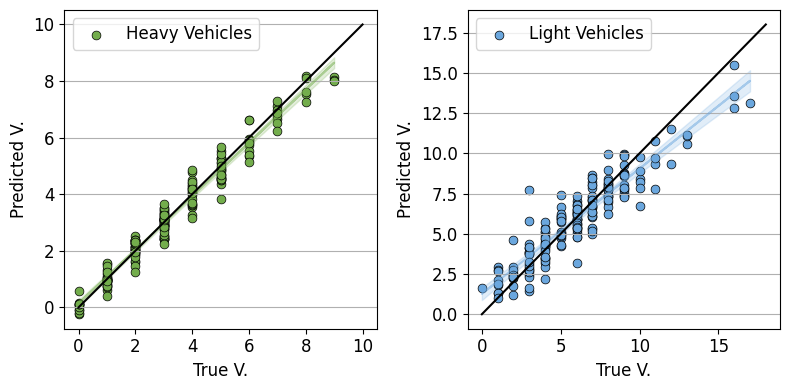

In [4]:
import scipy.stats as stats

fig, ax = plt.subplots(1, 2, figsize= (8,4))#,sharey=True)
methods = ['Heavy Vehicles', 'Light Vehicles']
files = ['y_camion', 'y_car']
base_string = './Results/uc2_results/Roccaprebalza_'
colors = ['#73AD4C', '#6BA7DE']

def plot_ci_manual(t, s_err, n, x, x2, y2, col, ax):
    ci = t * s_err * np.sqrt(1/n + (x2 - np.mean(x))**2 / np.sum((x - np.mean(x))**2))
    ax.fill_between(x2, y2 + ci, y2 - ci, color=col, alpha=0.2)

# Modeling with Numpy
def equation(a, b):
    """Return a 1D polynomial."""
    return np.polyval(a, b)

for i, lab in enumerate(methods):
    dataset = pd.read_csv(base_string+'autoencoder_'+files[i]+'.csv')
    d_int = np.round(np.asarray(dataset.values))
    d_float = (np.asarray(dataset.values))
    x = d_float[:,0]
    y = d_float[:,1]
    ax[i].scatter(x,y, label=lab,c=colors[i],s=40, edgecolor='k',linewidths =0.5)
    p, cov = np.polyfit(x, y, 1, cov=True)                     # parameters and covariance from of the fit of 1-D polynom.
    y_model = equation(p, x)                                   # model using the fit parameters; NOTE: parameters here are coefficients

    # Statistics
    n = y.size                                           # number of observations
    m = p.size                                                 # number of parameters
    dof = n - m                                                # degrees of freedom
    t = stats.t.ppf(0.995, n - m)                              # used for CI and PI bands
    
    x2 = np.linspace(np.min(x), np.max(x), 100)
    y2 = equation(p, x2)

    # Estimates of Error in Data/Model
    resid = y - y_model                           
    chi2 = np.sum((resid / y_model)**2)                        # chi-squared; estimates error in data
    chi2_red = chi2 / dof                                      # reduced chi-squared; measures goodness of fit
    s_err = np.sqrt(np.sum(resid**2) / dof)                    # standard deviation of the error
    ax[i].plot(x, y_model, color=colors[i], linewidth=1.5, alpha=0.5)  
    plot_ci_manual(t, s_err, n, x, x2, y2, colors[i], ax[i])
    if i == 0:
        ax[i].plot([0,10],[0,10], color = 'k')
    else:
        ax[i].plot([0,18],[0,18], color = 'k')
    ax[i].set_xlabel("True V.", fontsize = 12)
    ax[i].set_ylabel("Predicted V.", fontsize = 12)
    # ax[i].axis([0,10,0,10])
    ax[i].legend(fontsize=12)
    ax[i].yaxis.grid(True)
    ax[i].tick_params(labelsize=12)
plt.tight_layout()
plt.savefig('Results/images/Roccaprebalza_regression_autoencoder.pdf', dpi=600)

### 2) Pretrain impact plot

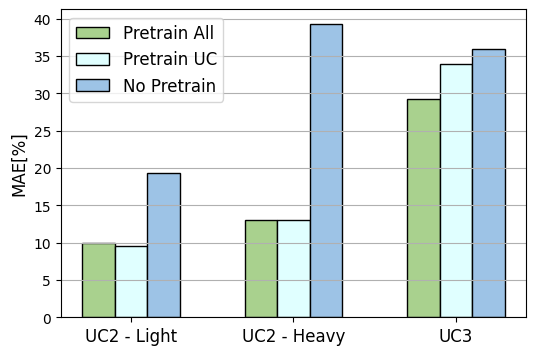

In [5]:
MAE_pretrain_all = [9.98,  13.10, 29.29]
MAE_pretrain = [9.54, 13.09, 33.89 ]
MAE_no_pretrain = [19.39, 39.32, 35.92]

# Create the figure and subplots
fig, axs = plt.subplots(figsize=(6, 4))
x = np.arange(3)
bar_width = 0.20

axs.bar(x - bar_width, MAE_pretrain_all, width=bar_width, color='#A9D18E', edgecolor = 'k', label='Pretrain All')
axs.bar(x , MAE_pretrain, width=bar_width, color='lightcyan', edgecolor = 'k', label='Pretrain UC')
axs.bar(x + bar_width, MAE_no_pretrain, width=bar_width, color='#9DC3E6', edgecolor = 'k', label='No Pretrain')
axs.set_ylabel('MAE[%]', fontsize=12)
axs.set_xticks(x)
axs.set_xticklabels(["UC2 - Light", "UC2 - Heavy", "UC3"], fontsize=12)
axs.legend(fontsize=12)
axs.yaxis.grid(True)
plt.subplots_adjust(hspace=0.1)
plt.savefig("Results/images/Pretraining.pdf", dpi=600)
plt.show()

### 3) Regular vs kd-enhanced fine-tuning plot

/tmp/ipykernel_243568/1974038877.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


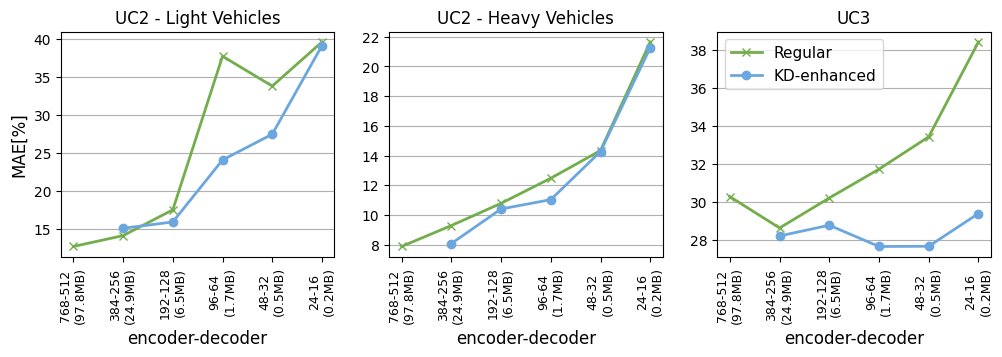

In [12]:
import matplotlib.gridspec as gridspec
# fig = plt.figure(figsize=(6,7))
fig = plt.figure(figsize=(12, 3))
# gs = gridspec.GridSpec(2, 4)
gs = gridspec.GridSpec(1, 3)
gs.update(wspace=0.2)
# gs.update(hspace=0.6)
linewidth = 2
x = np.arange(len(uc3_regular["embed_dim"].unique()))


ax1 = plt.subplot(gs[0, 0], )
ax1.set_title("UC2 - Light Vehicles", fontsize=12)
ax1.plot(x, uc2_regular[uc2_regular["car"] == "y_car"]["mape"], marker = 'x',linewidth=linewidth, label="Regular", color=colors[0])
ax1.plot(x[1:], uc2_kd[uc2_kd["car"] == "y_car"]["mape"][1:], marker = 'o', linewidth=linewidth, label="KD-enhanced", color=colors[1])
ax1.set_ylabel("MAE[%]", fontsize=12)
ax1.yaxis.grid(True)
ax1.set_xticks(x, [])
ax1.set_xlabel("encoder-decoder", fontsize=12)
ax1.set_xticks(x, ["{:.0f}-{:.0f}".format(e, d) for e,d in uc3_regular[["embed_dim", "decoder_dim"]].values], fontsize=9, rotation=90)
ax1.set_xticks(x, ["{:.0f}-{:.0f}\n({:.1f}MB)".format(e, d, s) for e,d,s in uc3_regular[["embed_dim", "decoder_dim", "size"]].values], fontsize=9, rotation=90)
# ax1.set_xticks(x, ["{:.0f}-{:.0f}\n({:.1f}MB)".format(e, d, s) for e,d,s in uc3_regular[["embed_dim", "decoder_dim", "size"]].values], fontsize=9, rotation=90)

ax2 = plt.subplot(gs[0, 1])
ax2.set_title("UC2 - Heavy Vehicles", fontsize=12)
ax2.plot(x, uc2_regular[uc2_regular["car"] == "y_camion"]["mape"], marker = 'x',linewidth=linewidth, label="Regular", color=colors[0])
ax2.plot(x[1:], uc2_kd[uc2_kd["car"] == "y_camion"]["mape"][1:], marker = 'o', linewidth=linewidth, label="KD-enhanced", color=colors[1])
# ax2.set_ylabel("MAE[%]", fontsize=12)
ax2.yaxis.grid(True)
ax2.set_xticks(x, [])
ax2.set_xlabel("encoder-decoder", fontsize=12)
# ax2.set_xticks(x, ["{:.0f}-{:.0f}".format(e, d) for e,d in uc3_regular[["embed_dim", "decoder_dim"]].values], fontsize=9, rotation=90)
ax2.set_xticks(x, ["{:.0f}-{:.0f}\n({:.1f}MB)".format(e, d, s) for e,d,s in uc3_regular[["embed_dim", "decoder_dim", "size"]].values], fontsize=9, rotation=90)
# ax2.set_xticks(x, ["{:.0f}-{:.0f}\n({:.1f}MB)".format(e, d, s) for e,d,s in uc3_regular[["embed_dim", "decoder_dim", "size"]].values], fontsize=9, rotation=90)

ax3 = plt.subplot(gs[0, 2])
ax3.set_title("UC3", fontsize=12)
ax3.plot(x, uc3_regular["mape"], marker = 'x',linewidth=linewidth, label="Regular", color=colors[0])
ax3.plot(x[1:], uc3_kd["mape"][1:], marker = 'o', linewidth=linewidth, label="KD-enhanced", color=colors[1])
# ax3.set_ylabel("MAE[%]", fontsize=12)
ax3.yaxis.grid(True)
ax3.legend(fontsize=11)
# ax3.set_xlabel("embed-decoder\n(model size)", fontsize=12)
ax3.set_xlabel("encoder-decoder", fontsize=12)
ax3.set_xticks(x, ["{:.0f}-{:.0f}\n({:.1f}MB)".format(e, d, s) for e,d,s in uc3_regular[["embed_dim", "decoder_dim", "size"]].values], fontsize=9, rotation=90)
# ax3.set_xticks(x, ["{:.0f}-{:.0f}".format(e, d) for e,d in uc3_regular[["embed_dim", "decoder_dim"]].values], fontsize=9, rotation=90)

plt.subplots_adjust(hspace=0.6)
plt.subplots_adjust(bottom=0.13)
# plt.subplots_adjust(left=0.09)
plt.tight_layout()
plt.savefig("Results/images/regular_vs_kd.pdf", dpi=600, bbox_inches='tight')
plt.show()